In [ ]:
#%%

import os
import deeptrack as dt
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassJaccardIndex
import deeplay as dl
from lightning.pytorch.loggers import CSVLogger
import pandas as pd
from lightning.pytorch.callbacks import EarlyStopping

if not os.path.exists("tissue_images_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/tissue_images_dataset")

raw_path = os.path.join("tissue_images_dataset", "stack1", "raw")
seg_path = os.path.join("tissue_images_dataset", "stack1", "labels")

raw_paths = dt.sources.ImageFolder(root=raw_path)
seg_paths = dt.sources.ImageFolder(root=seg_path)

paths = dt.sources.Source(raw=raw_paths, label=seg_paths)
train_paths, val_paths, test_paths = \
    dt.sources.random_split(paths, [0.8, 0.1, 0.1])

train_srcs = train_paths.product(flip_ud=[True, False], flip_lr=[True, False])
val_srcs = val_paths.constants(flip_ud=False, flip_lr=False)
test_srcs = test_paths.constants(flip_ud=False, flip_lr=False)

sources = dt.sources.Join(train_srcs, val_srcs, test_srcs)

print(f"Raw images: {len(raw_paths)}")
print(f"Segmentation labels: {len(seg_paths)}")

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


Raw images: 20
Segmentation labels: 20


In [ ]:
# %% define pipline and datasets

def select_labels(class_labels):
    """Create a function to filter and remap labels in a segmentation map."""
    def inner(segmentation):
        seg = segmentation.copy()
        mask = seg * np.isin(seg, class_labels).astype(np.uint8)
        new_seg = (np.select([mask == c for c in class_labels],
                             np.arange(len(class_labels)) + 1)
                   .astype(np.uint8).squeeze())
        one_hot_encoded_seg = np.eye(len(class_labels) + 1)[new_seg]
        return one_hot_encoded_seg        
    return inner

im_pip = dt.LoadImage(sources.raw.path) >> dt.NormalizeMinMax()
seg_pip = (dt.LoadImage(sources.label.path)
           >> dt.Lambda(select_labels, class_labels=[255, 191]))
pip = ((im_pip & seg_pip) >> dt.FlipLR(sources.flip_lr)
       >> dt.FlipUD(sources.flip_ud) >> dt.MoveAxis(2, 0)
       >> dt.pytorch.ToTensor(dtype=torch.float))

train_dataset = dt.pytorch.Dataset(pip, train_srcs)
val_dataset = dt.pytorch.Dataset(pip, val_srcs)

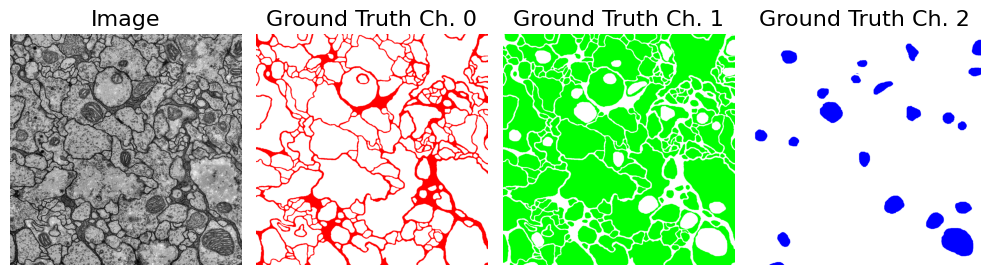

In [ ]:
#%% Plot iput images and ground-truth

image, segmentation = train_dataset[0]

fig, axs = plt.subplots(1, 4, figsize=(10, 5))

axs[0].imshow(image.permute(1, 2, 0), cmap="gray")
axs[0].set_title("Image", fontsize=16)
axs[0].set_axis_off()

for i in range(segmentation.shape[0]):
    segmentation_color = torch.ones_like(segmentation)
    for j in range(segmentation.shape[0]):
        if j != i: segmentation_color[j, ...] = 1 - segmentation[i, ...]
    axs[i + 1].imshow(segmentation_color.permute(1, 2, 0))
    axs[i + 1].set_title(f"Ground Truth Ch. {i}", fontsize=16)
    axs[i + 1].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
#%% Class for Jaccard Index with multiple classes and loaders and Unet

class ArgmaxJI(MulticlassJaccardIndex):
    """Compute Jaccard Index for multi-class predictions after argmax."""

    def update(self, preds, targets):
        """Update Jaccard Index using argmax of class predictions."""
        super().update(preds.argmax(dim=1), targets.argmax(dim=1))

ji_metric = ArgmaxJI(num_classes=3)

In [ ]:
#%% unet_no_skip

unet_no_skip = dl.ConvolutionalEncoderDecoder2d(in_channels=1, encoder_channels=[16, 32, 64, 128], decoder_channels=[64,32,16],
                                        out_channels=3)

unet_reg_template = dl.Regressor(
    model=unet_no_skip, loss=torch.nn.CrossEntropyLoss(), metrics=[ji_metric],
    optimizer=dl.Adam(),
)
unet_reg = unet_reg_template.create()

print(unet_reg)

train_loader = dl.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = dl.DataLoader(val_dataset, batch_size=2)

Regressor(
  (loss): CrossEntropyLoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=test
  )
  (model): ConvolutionalEncoderDecoder2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), str

In [ ]:
#%% Training

logger = CSVLogger("logs", name="train_100_epochs")
trainer = dl.Trainer(max_epochs=100, accelerator="auto", logger=logger)
trainer.fit(unet_reg, train_loader, val_loader)

INFO: 
  | Name          | Type                          | Params | Mode 
------------------------------------------------------------------------
0 | loss          | CrossEntropyLoss              | 0      | train
1 | train_metrics | MetricCollection              | 0      | train
2 | val_metrics   | MetricCollection              | 0      | train
3 | test_metrics  | MetricCollection              | 0      | train
4 | model         | ConvolutionalEncoderDecoder2d | 429 K  | train
5 | optimizer     | Adam                          | 0      | train
------------------------------------------------------------------------
429 K     Trainable params
0         Non-trainable params
429 K     Total params
1.717     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                          | Params | Mode 
----------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

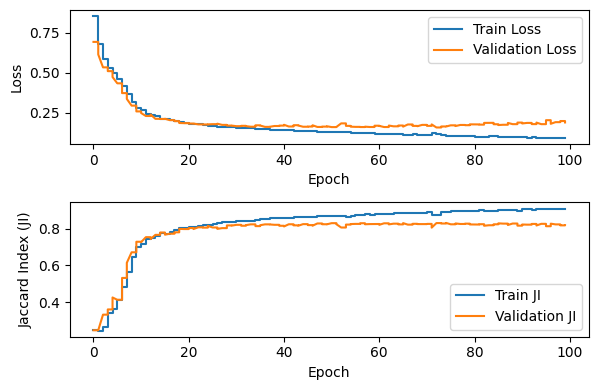

In [ ]:
#%% Plot overfitting

metrics = pd.read_csv(os.path.join(logger.log_dir, "metrics.csv")).ffill()

def plot_training_metrics(m):
    """Plot training metrics by epoch."""
    fig, axs = plt.subplots(2, figsize=(6, 4))

    axs[0].plot(m["epoch"], m["train_loss_epoch"], label="Train Loss")
    axs[0].plot(m["epoch"], m["val_loss_epoch"], label="Validation Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(m["epoch"], m["trainArgmaxJI_epoch"], label="Train JI")
    axs[1].plot(m["epoch"], m["valArgmaxJI_epoch"], label="Validation JI")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Jaccard Index (JI)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    
plot_training_metrics(metrics)

In [ ]:
# %% Preventing overfitting

early_stop_unet_reg = unet_reg_template.create()

early_stop = EarlyStopping(monitor="valArgmaxJI_epoch", mode="max", patience=5)
early_stop_logger = CSVLogger("logs", name="train_until_stagnation")

early_stop_trainer = dl.Trainer(max_epochs=100, logger=early_stop_logger,
                                callbacks=[early_stop])
early_stop_trainer.fit(early_stop_unet_reg, train_loader, val_loader)

INFO: 
  | Name          | Type                          | Params | Mode 
------------------------------------------------------------------------
0 | loss          | CrossEntropyLoss              | 0      | train
1 | train_metrics | MetricCollection              | 0      | train
2 | val_metrics   | MetricCollection              | 0      | train
3 | test_metrics  | MetricCollection              | 0      | train
4 | model         | ConvolutionalEncoderDecoder2d | 429 K  | train
5 | optimizer     | Adam                          | 0      | train
------------------------------------------------------------------------
429 K     Trainable params
0         Non-trainable params
429 K     Total params
1.717     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                          | Params | Mode 
----------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

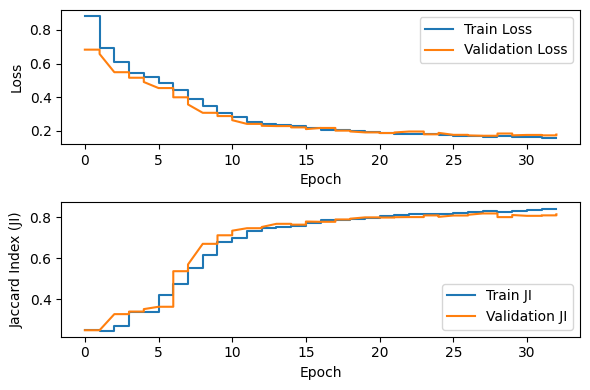

In [ ]:
#%% Plot new overfittings results

metrics = (pd.read_csv(os.path.join(early_stop_logger.log_dir, "metrics.csv"))
           .ffill())
plot_training_metrics(metrics)

In [ ]:
#%% Estimate segmentation with the U-net

test_dataset = dt.pytorch.Dataset(pip, test_srcs)
test_loader = dl.DataLoader(test_dataset, batch_size=2, shuffle=False)
trainer.test(early_stop_unet_reg, test_loader)
pred_seg = torch.cat(trainer.predict(early_stop_unet_reg, test_loader), dim=0)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    testArgmaxJI_epoch     │    0.8186124563217163     │
│      test_loss_epoch      │    0.19573161005973816    │
└───────────────────────────┴───────────────────────────┘

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

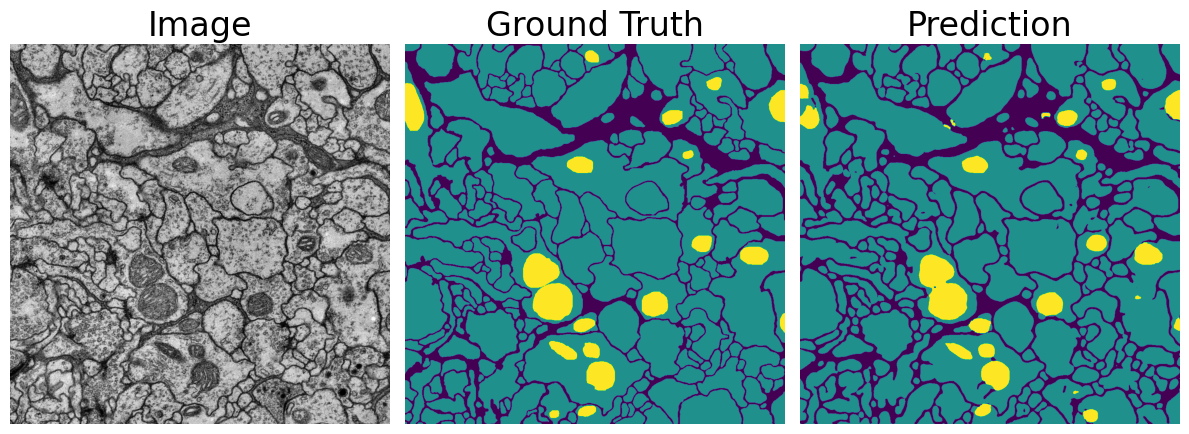

tensor(0.8148)


In [ ]:
#%% Plot and calc test Jaccard Index

test_image, test_seg = test_dataset[0]

fig, axs = plt.subplots(1, 3, figsize=(12, 9))

axs[0].imshow(test_image[0], cmap="gray")
axs[0].set_title("Image", fontsize=24)
axs[0].set_axis_off()

axs[1].imshow(test_seg.argmax(dim=0))
axs[1].set_title("Ground Truth", fontsize=24)
axs[1].set_axis_off()

axs[2].imshow(pred_seg[0].argmax(dim=0))
axs[2].set_title("Prediction", fontsize=24)
axs[2].set_axis_off()

plt.tight_layout()
plt.show()

ji_metric.reset()
ji_seg = ji_metric(pred_seg[0].unsqueeze(0), test_seg.unsqueeze(0))

print(ji_seg)